In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Морфологична скелетонизация на изображения

## Скелетонизация

### Дефиниция

Скелетонизацията е трансформация, която се извършва над бинаризирани изображения. Тази трансформация се изразява в намаляването на броя на пикселите от изображението до изображение с ширина 1 пиксел, което в голяма степен запазва формата и свързаността на оригиналния регион, но в същото време по-голямата част от пикселите на изображението се изключват. Това получено изображение прилича на скелет, откъдето идва и името на трансформацията. Скелетонът съдържа тези пиксели, които са на еднакво разстояние от границите на изображението.

Скелетонът запазва и показва топологичните и геометричните свойства на изображението - свързаност, топология, дължина, посока и ширина.

Скелетонизацията е необратима операция. При нея част от информацията се губи и в много случаи оригиналното изображение не може точно да бъде възстановено. Нуждата от възстановяване на оригиналното изображение би означавало, че скелетонизацията се използва като компресия, но тя не се ползва за това в практиката.

### Приложение

Скелетонизация е полезна в следните случаи, но не само:
- По-бързо изпълнение на алгоритми, които биха отнели много време върху оригиналното изображения или биха имали трудност при работа с оригиналното изображение
  -  Работа с пръстови отпечатъци. Прилагане на скелетонизация, в комплект с други методи за обработка, може значително да подобри изображението<sup>1</sup>
  <div><img alt="Example of skeletonization of a fingerprint" src="images/skeleton_fingerprint.png" width="1000"/></div>
  - Разпознаване на жестове на ръка. Работата с оригиналното изображение е по-трудна и отнема повече ресурси. Скелетонизацията на пръстите на ръката води до по-лесна работа с тези изображения.

### Пример

Как изглежда едно изображение след като е скелетонизирано най-лесно се разбира с пример<sup>2</sup>:
<div><img alt="Example of skeletonization of a horse binary image" src="images/skeleton_horse.png" width="500"/></div>

Две различни изображения могат да имат еднакъв скелетон<sup>3</sup>, тоест скелетонът не определя еднозначно оригиналното изображение:
<div>
    <img alt="Not unique skeleton - rectangle" src="images/not_unique_skeleton_rect.png" width="250"/>
    <img alt="Not unique skeleton - x shape" src="images/not_unique_skeleton_x.png" width="250"/>
</div>


### Имплементация

В този notebook ще разгледаме имплементация на скелетонизацията чрез морфологични операции. Ще разгледаме алгоритъм, който използва повторно прилагане на морфологичните операции ерозия и дилатация. Ще разгледаме също и алгорими за изтъняване (thinning) и подрязване (pruning).

## Математическа морфология

Терминът морфология има гръцки произход (μορφή — „форма“ и λόγος — „наука“) и буквално значи наука за формите.

Терминът морфология се използва и в други науки - биология, езикознание, астрономия. Използва се в биологията във връзка с изучаване на формите и структурите на растения и животни. В езикознанието се отнася към изучаването на формите на думите – техния строеж и значение. 

Математическата морфология е разработена през 60-те години на XX век за решаване на проблеми на минералогията и петрографията. Информация за произхода на математическата морфология може да бъде намерен в [https://smil.cmm.minesparis.psl.eu/publis/C-72.pdf](https://smil.cmm.minesparis.psl.eu/publis/C-72.pdf). Първоначално математическата морфология е разработена за анализ на двоични изображения, които могат да бъдат разглеждани математически като множества. След това тя бива надградена за работа и върху не-бинаризирани изображения. В този notebook ще разглеждаме само бинаризирани изображения.

Математическата морфология има по-тясна и специализирана дефиниция. Математическата морфология включва нелинейни методи за обработка и анализ на изображения. Тя е теория и техника за обработка и анализ на геометрични структури, базирана на теорията на множествата, теорията на решетките, топология и случайни функции<sup>3</sup>. 

Математическата морфология разглежда изображенията като множество/решетка от пиксели. Това е един наивен подход, в които липсва знание за разглежданото изображение. Като следствие откриваме проблеми - например при скелетонизацията чрез морфологични операции можем да загубим свързаността.

Използваме математическата морфология като прилагаме морфологични операции върху изображенията.

## Морфологична операция

Морфологичната операция принадлежи към класа на нелинейните оператори за съседство. Стойността на всеки пиксел се определя от стойностите на пиксели, които са в съседство с него. Чрез настройване на размера и формата, определящи кои пиксели са съседни, се конструират морфологични операции, които са чувствителни към специфични форми във входното изображение.

Две от базовите морфологични операции са Ерозия и Дилатация. Ерозията е операция, която премахва пиксели от границата на изображения, а дилатацията добавя пиксели към границата.

Съседството се дефинира като структурен елемент - матрица от числата 0 или 1. Пикселът, с който работим, е централният пиксел. Честа практика, за да има такъв централен пиксел, е размерите на структурния елемент да са нечетни числа. При прилагане на операция за съседени пиксели на даден пиксел се приемат само тези, които при налагане на структурния елемент върху изображението така, че централният пиксел на структурния елемент да съвпада с разглеждания пиксел, имат стойност 1. Най-често се използват структурни елементи с размери 3х3 и 5х5. Не е задължително структурният елемент да има квадратна форма. Структурни елементи с размери 3х5 или 7х13 са валидни.

По-долу са показани два структурни елемента с различна форма - елипса и кръст. Всички бели пиксели (стойност 1 в структурния елемент) са съседни на централния пиксел. Всички черни пиксели (стойност 0 в структурния елемент) не са съседни на централния пиксел.

<AxesSubplot:title={'center':'Cross Structure Element'}>

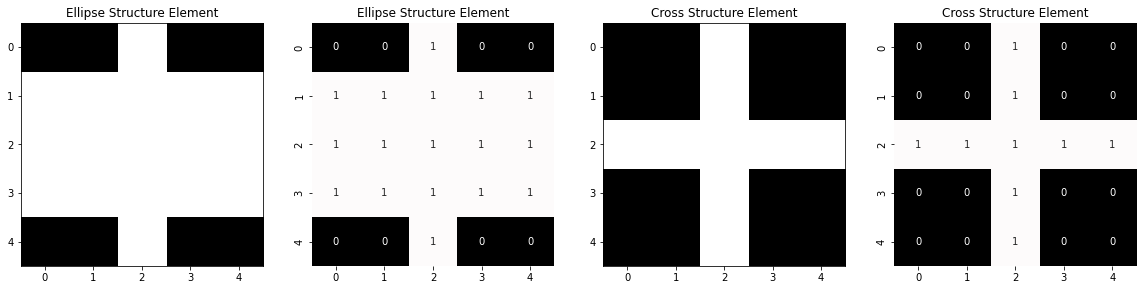

In [132]:
# structuring elements
kernel=(5,5)
figsize=(20,20)
ellipse_se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel)
cross_se = cv2.getStructuringElement(cv2.MORPH_CROSS, kernel)
rect_se = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=figsize)
ax1.set_title('Ellipse Structure Element')
ax1.imshow(ellipse_se, 'gray')
ax2.set_title('Ellipse Structure Element')
sns.heatmap(ellipse_se, annot=True, cmap='gist_earth', ax=ax2, cbar=False, square=True)

ax3.set_title('Cross Structure Element')
ax3.imshow(cross_se, 'gray')
ax4.set_title('Cross Structure Element')
sns.heatmap(cross_se, annot=True, cmap='gist_earth', ax=ax4, cbar=False, square=True)


## Морфологична операция Ерозия

### Дефиниция
Операцията се представя се със символа ⊖.

Името на тази операция е взаимствано си от ерозията в реалния свят. Под ерозия в реалния свят разбираме процес, при който под някакво външно въздействие се премахва слой от почвата/скалите. Естественият темп на ерозия се контролира от действието на геоморфологични подбудители.

Нека **E** е числова решетка и **A** е бинарно изображение в **E**. Ерозия върху изображението **A** със структурен елемент **B** дефинираме като:

$A\ominus B=\{z\in E|B_{{z}}\subseteq A\}$,</br>
където B<sub>z</sub> е транслацията на структурния елемент B с вектор z:</br>
${\displaystyle}B_{z}=\{b+z|b\in B\}, {\displaystyle}\forall z\in E.$

Алтернативно ерозията може да се дефинира и по следния начин:</br>
${\displaystyle}A\ominus B=\bigcap _{{b\in B}}A_{{-b}}$,</br>
където с A<sub>−b</sub> се отбелязва транслацията на A с -b.

Нека с f(x) отбелязваме изображението, а с b(x) - структурния елемент. При ограничение за работа само върху бинаризирани изображения тези дефиниции се свеждат до:</br>
$(f\ominus b)(x)=\min _{{b\in B}}[f(x+b)]$<br/>
$(f\ominus b)(x)=\bigwedge _{{b\in B}}f_{-b}$

Неформално, на всеки пиксел даваме стойност, която е минималната стойност на пиксел в съседство. Това означава, че в бинаризирано изображение пиксели от изображението, които имат за съсед пиксел от фона, ще получат стойност 0 (черен цвят, фон). Основното действие на ерозията се изразява в намаляване (ерозиране) на границите на изображението и увеличаване на дупките в него.

### Имплементация

Използваме готовата имплементация включена в opencv2: `cv2.erode(img, kernel)`

## Морфологична операция Дилатация (Експандиране)

### Дефиниция
Нека **E** е числова решетка и **A** е бинарно изображение в **E**. Дилатация върху изображението **A** със структурен елемент **B** дефинираме като:

$A\oplus B=\{z\in E\mid (B^{s})_{z}\cap A\neq \varnothing \}$,</br>
където $B^{s}=\{x\in E\mid -x\in B\}$:</br>

Алтернативно ерозията може да се дефинира и по следния начин:</br>
$A\oplus B = \bigcup_{b\in B} A_b$,</br>
където с A<sub>b</sub> се отбелязва транслацията на A с b.

Дилатацията е комутативна операция, тоест:</br>
$A\oplus B=B\oplus A=\bigcup _{{a\in A}}B_{a}.$

Нека с f(x) отбелязваме изображението, а с b(x) - структурния елемент. При ограничение за работа само върху бинаризирани изображения тези дефиниции се свеждат до:</br>
$(f\oplus b)(x)=\max _{{b\in B}}[f(x+b)]$<br/>
$(f\oplus b)(x)=\bigvee _{{b\in B}}f_{-b}$

Неформално, на всеки пиксел даваме стойност, която е максималната стойност на пиксел в съсество. Това означава, че в бинаризирано изображение пиксели от фона, които имат за съсед пиксел от изображението, ще получат стойност 1 (бял цвят, изображение). Основното действие на дилатацията се изразява в увеличаване (експандиране) на изображението и запълване на дупките в него.

### Имплементация

Използваме готовата имплементация включена в opencv2: `cv2.dilate(img.kernel)`

## Морфологични операции Отваряне и Затваряне

Разгледаните операции Ерозия и Дилатация са базови. Като такива те имат своите негативни ефекти.
Чрез тях обаче дефинираме подобрени/композитни морфологични операции. Две такива операции са Отваряне и Затваряне.

### Дефиниция Отваряне

Операцията Отваряне дефинираме чрез прилагане на ерозия чрез структурен елемент B, а след това дилатация чрез B̂, където B̂ е получен чрез транспонация на B. Записваме ${\displaystyle A\circ B=(A\ominus B)\oplus B̂}$

Неформално, последователното прилагане на ерозия и дилатация има следния ефект - ерозията премахва частите от *изображението*, които са по-малки от структурния елемент, а дилатацията връща размерите на останалите части. Точността на реконструираните части зависи от формата на структруния елемент и формата на обектите, върху които се прилага.

### Дефиниция Затваряне

Операцията Затваряне дефинираме чрез прилагане на на дилатация чрез структурен елемент B, а след това ерозия чрез B̂, където B̂ е получен чрез транспонация на B. Записваме $A\bullet B=(A\oplus B)\ominus B̂$.

Неформално, последователното прилагане на дилатация и ерозия има следния ефект - дилатацията премахва частите от *фона*, които са по-малки от структурния елемент, а ерозията връща размерите на останалите части. Точността на реконструираните части зависи от формата на структруния елемент и формата на обектите, върху които се прилага.

### Уточнения

В много от случаите разглежданите структурни елементи са симетрични, т.е. транспонирането има поведение на идентитет.

### Приложение
Тези две операции са в основата на морфологичното премахването на шум от изображения. От описанието става видно, че операцията Отваряне може да се използва за изчистване на шум от изображението, а операцията Затваряне - от фона. Операцията Отваряне също може да се използва и за намиране на специфични форми в изображние.

### Имплементация

Използваме готовата имплементация включена в openv2: `cv2.morphologyEx(img, cv2.MORPH_OPEN | cv2.MORPH_CLOSE, kernel)`

## Скелетонизация чрез многократно прилагане на Ерозия и Отваряне

Разглеждаме следния алгоритъм:
1. Бинаризираме изображението.
2. Копираме изображението, с което ще работим, в нов обект с име img.
3. Ако има пиксели от изображението, продължаваме, ако няма пиксели преминаваме към стъпка 9.
4. Прилагаме ерозия върху изображението и запазваме резултат в нов обект erode.
5. Прилагаме отваряне към ерозираното изображение erode и запазваме резултата в нов обект opening
6. Взимаме пикселите, които се срещат в erode, но не и в opening и ги добавяме (чрез логическо или) в обекта, пазещ крайния резултат.
7. Копираме изобржението erode в img.
8. Връщаме се към стъпка 3
9. Финал


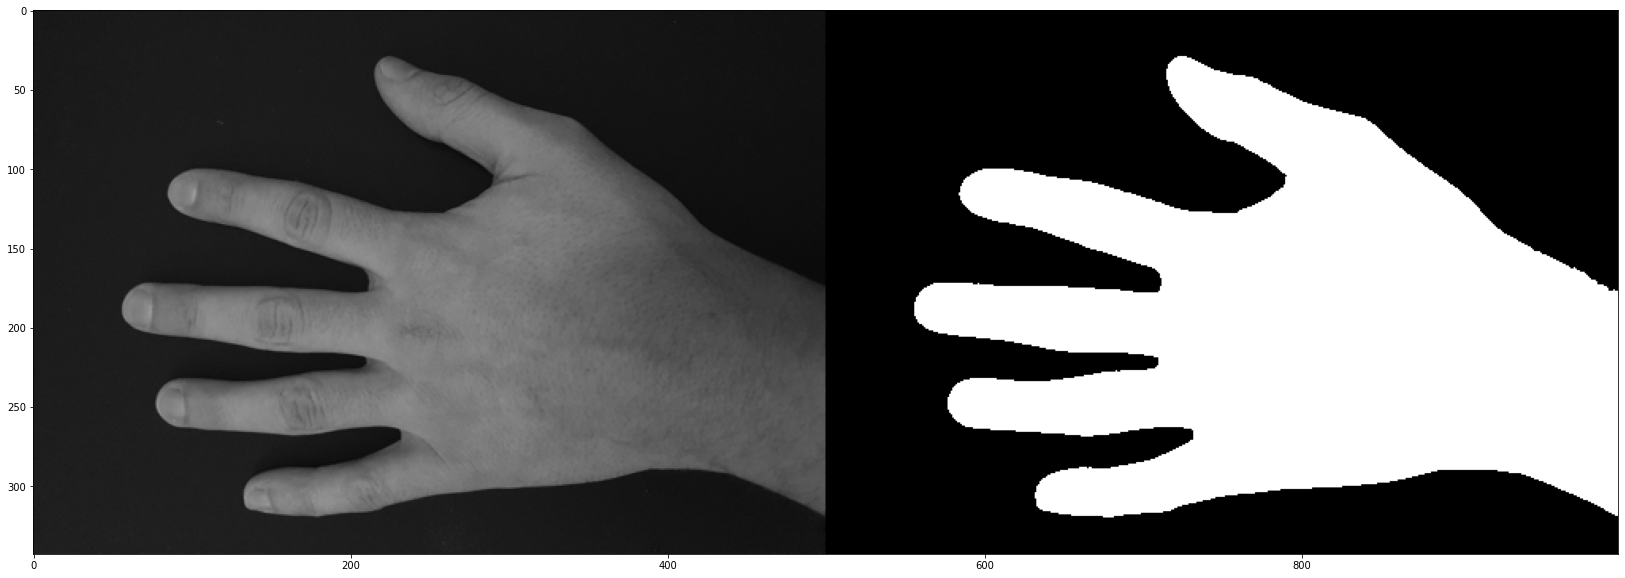

In [116]:
# Подготовка на изображението, с което ще работим - ръката на автора
hand_img = cv2.imread('images/hand3.jpeg', cv2.IMREAD_GRAYSCALE)
bin_hand = hand_img.copy()
t = 40
bin_hand[bin_hand <= t] = 0
bin_hand[bin_hand > t] = 255

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
# Прилагане на морфологично отваряне за доизчистване на артефактите от фона
bin_hand = cv2.morphologyEx(bin_hand, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(40,10))
plt.imshow(np.concatenate((hand_img, bin_hand), axis=1), 'gray')

In [153]:
kernel_rect3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
kernel_rect5 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
# kernel_rect5 = np.array([[0, 0, 0, 0, 0],[0, 1, 1, 1, 0],[0, 1, 1, 1, 0],[0, 1, 1, 1, 0],[0, 0, 0, 0, 0]], dtype=np.uint8)
kernel_ellipse5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
kernel_cross5 = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))

j = 0
outputs = {}
output_lists = {}
for kernel in (kernel_rect3, kernel_rect5, kernel_ellipse5, kernel_cross5):
    img = bin_hand.copy()
    output = np.zeros(img.shape, dtype=np.uint8)
    output_list = []
    i = 0

    while cv2.countNonZero(img):
        i = i + 1
        erode = cv2.erode(img, kernel)
        opening = cv2.morphologyEx(erode, cv2.MORPH_OPEN, kernel)
        subset = erode - opening
        output = cv2.bitwise_or(subset, output)
        output_list.append(output)
        img = erode.copy()
        
    outputs[j] = output
    output_lists[j] = output_list
    j = j + 1

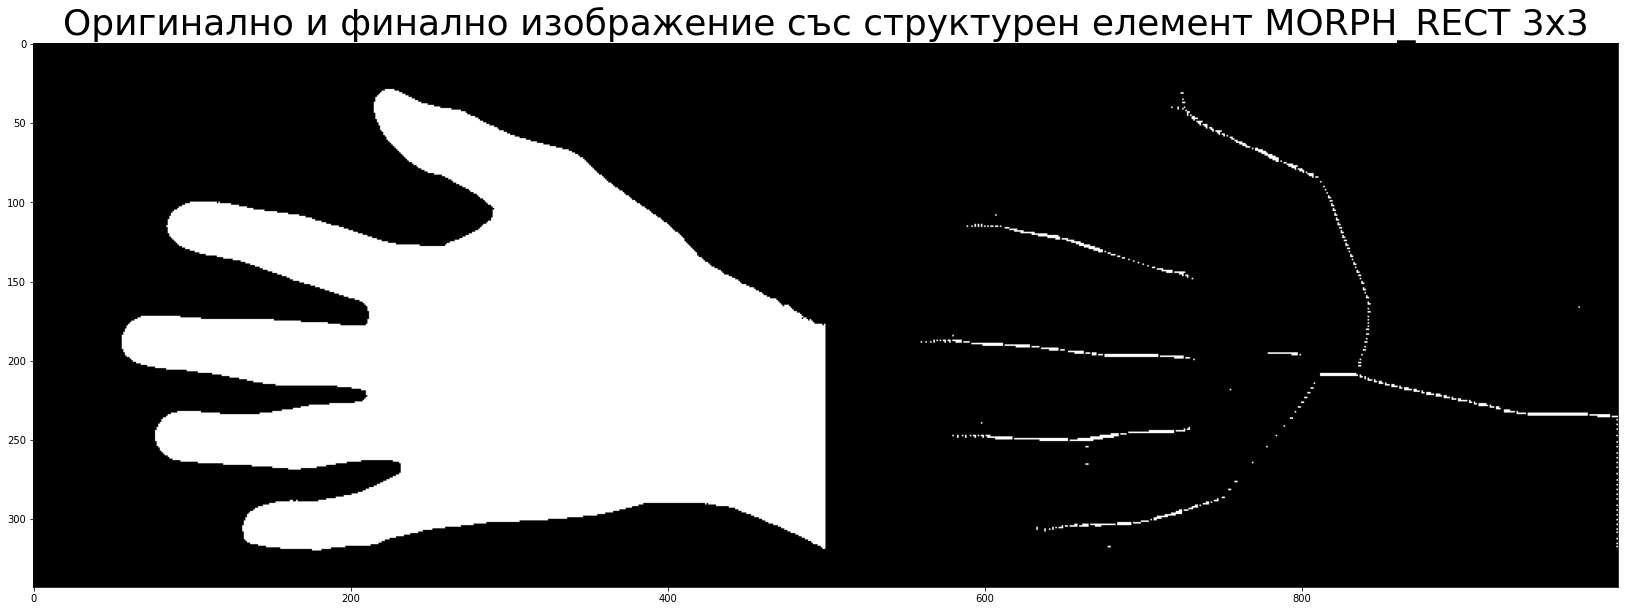

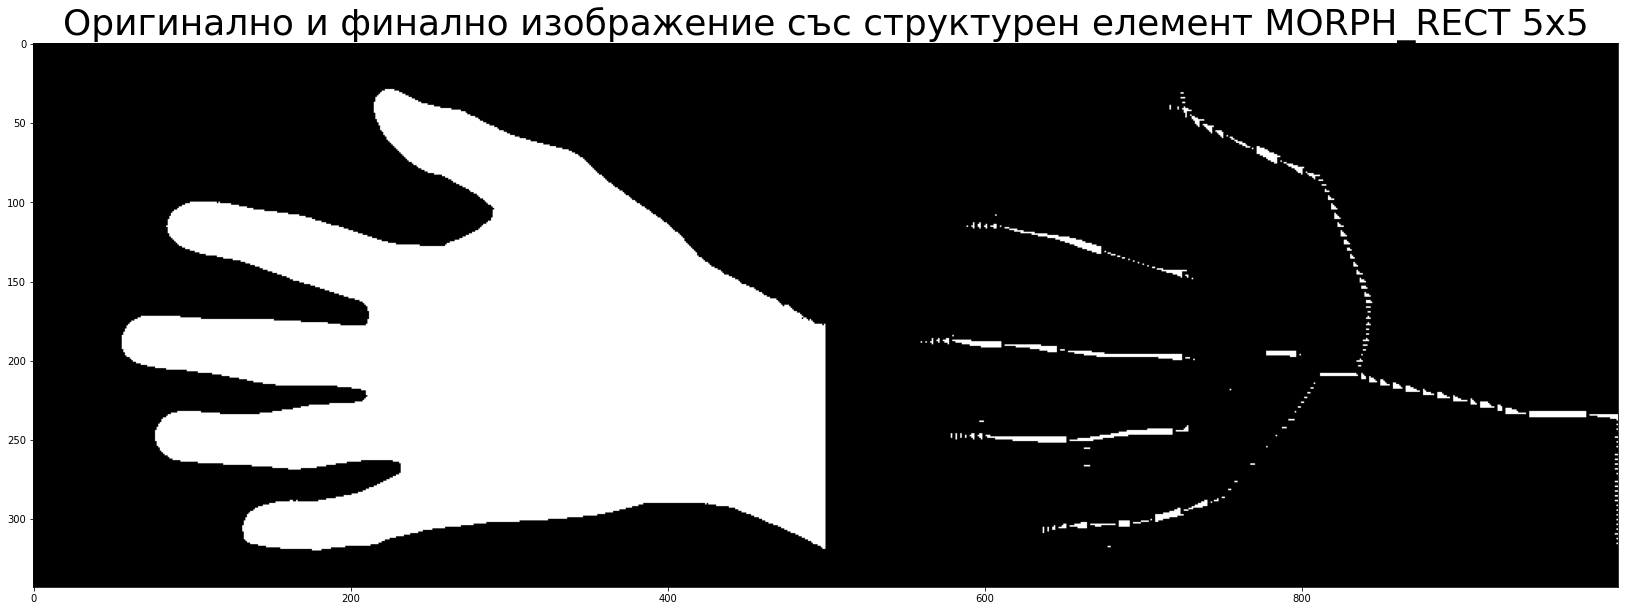

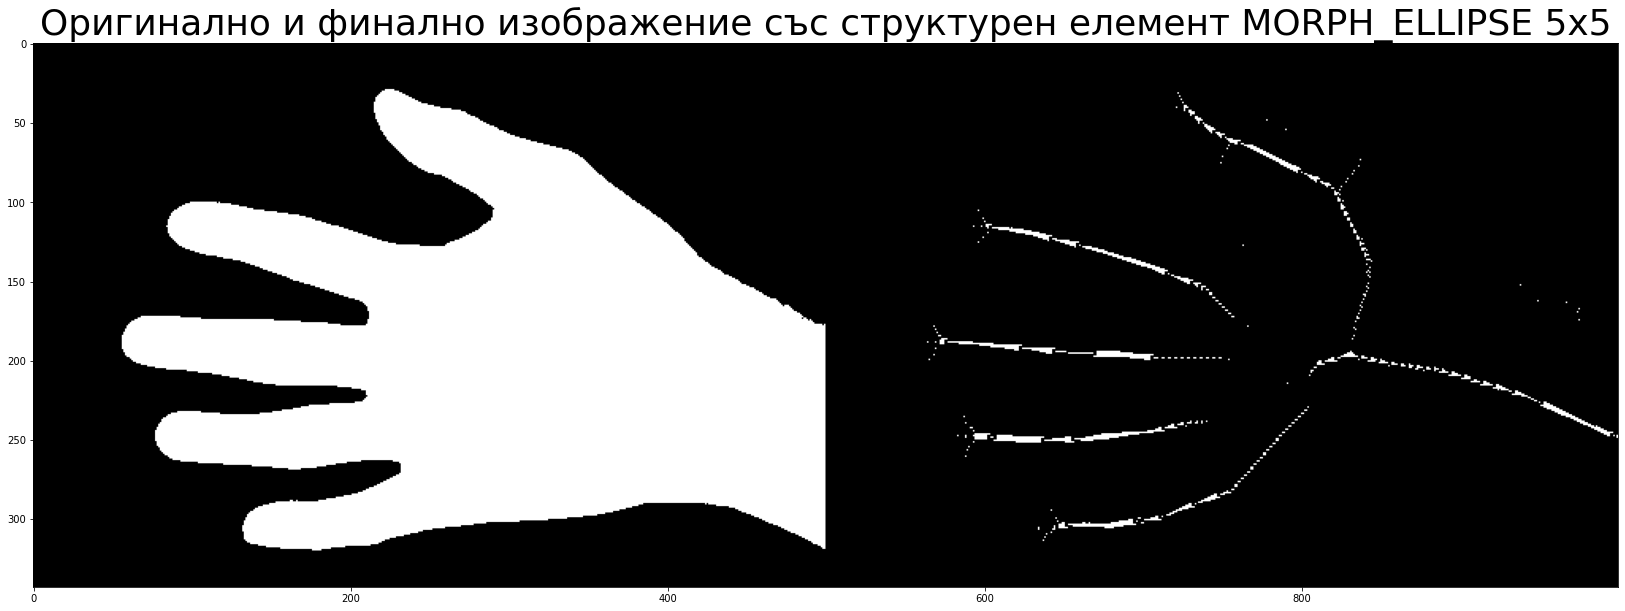

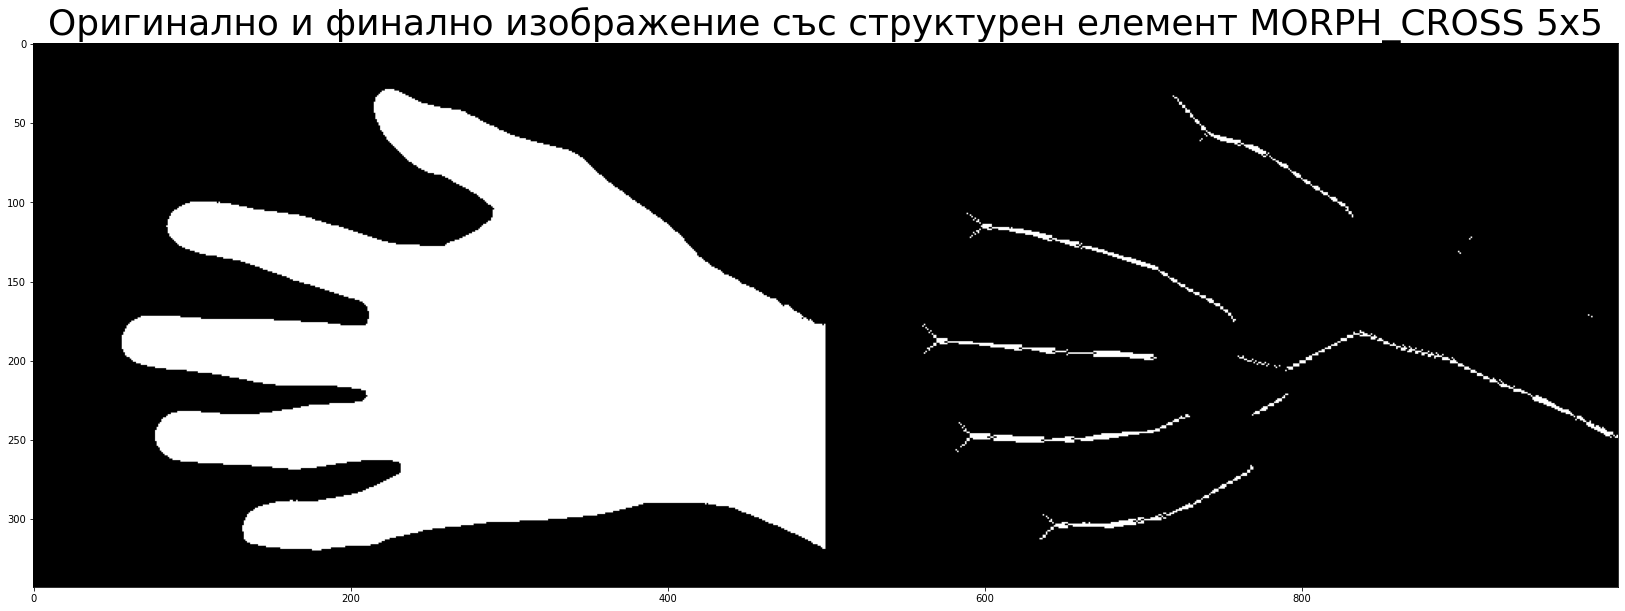

In [154]:
plt.figure(figsize=(40,10))
plt.title("Оригинално и финално изображение със структурен елемент MORPH_RECT 3x3", fontsize = 36)
plt.imshow(np.concatenate((bin_hand, outputs[0]), axis=1), 'gray')

plt.figure(figsize=(40,10))
plt.title("Оригинално и финално изображение със структурен елемент MORPH_RECT 5x5", fontsize = 36)
plt.imshow(np.concatenate((bin_hand, outputs[1]), axis=1), 'gray')

plt.figure(figsize=(40,10))
plt.title("Оригинално и финално изображение със структурен елемент MORPH_ELLIPSE 5x5", fontsize = 36)
plt.imshow(np.concatenate((bin_hand, outputs[2]), axis=1), 'gray')

plt.figure(figsize=(40,10))
plt.title("Оригинално и финално изображение със структурен елемент MORPH_CROSS 5x5", fontsize = 36)
plt.imshow(np.concatenate((bin_hand, outputs[3]), axis=1), 'gray')

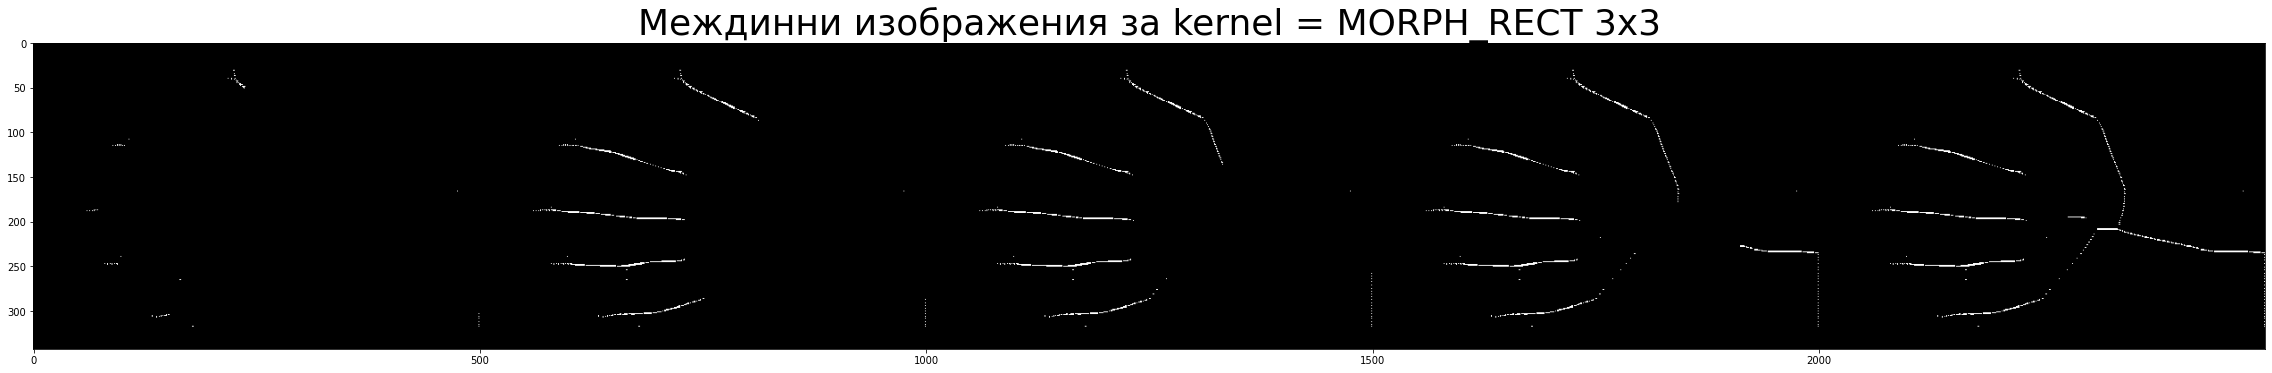

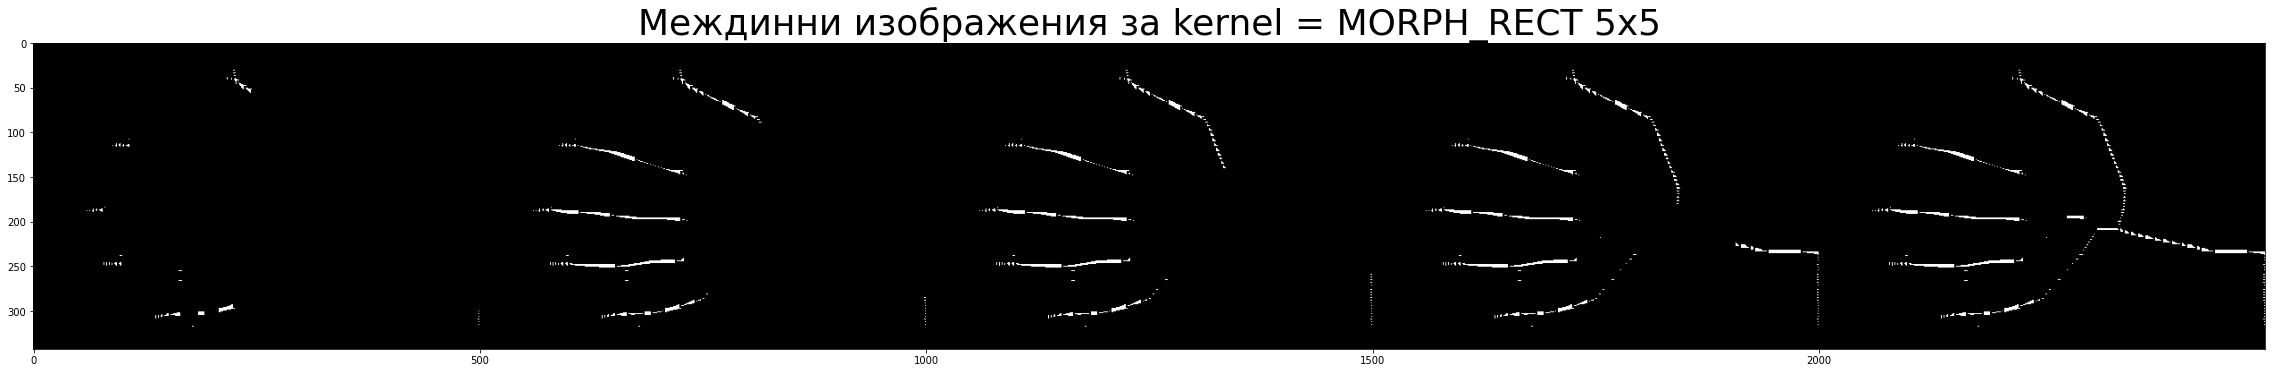

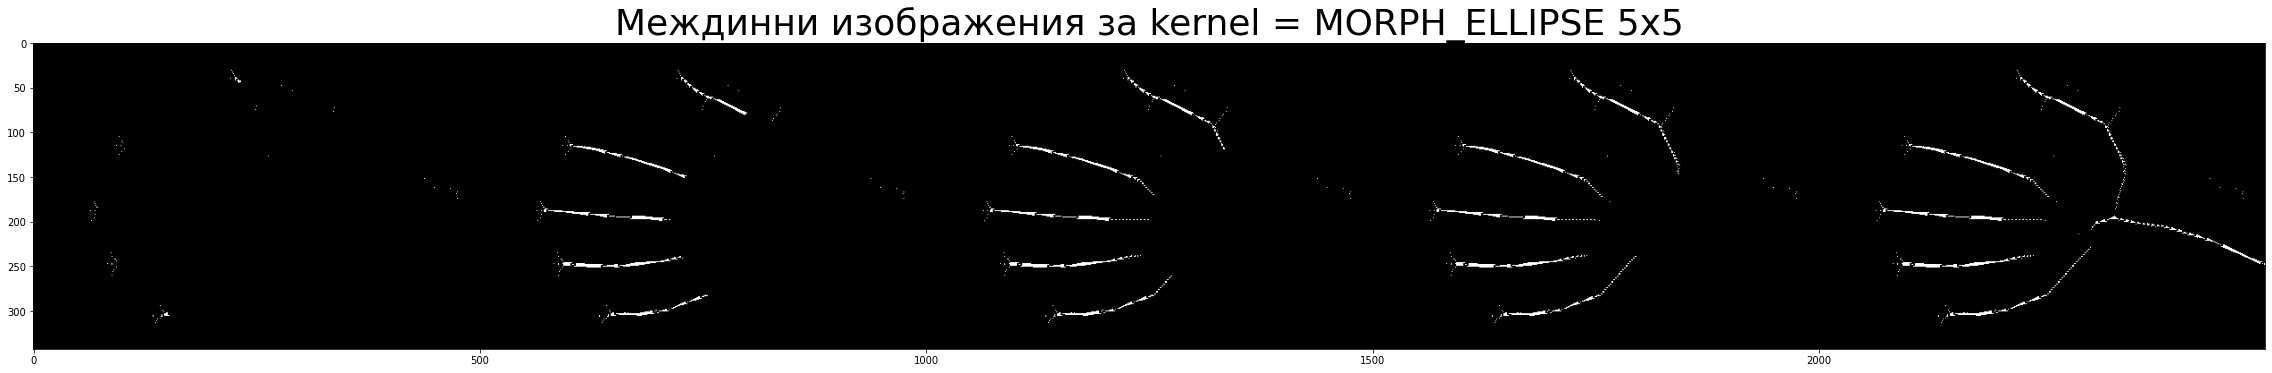

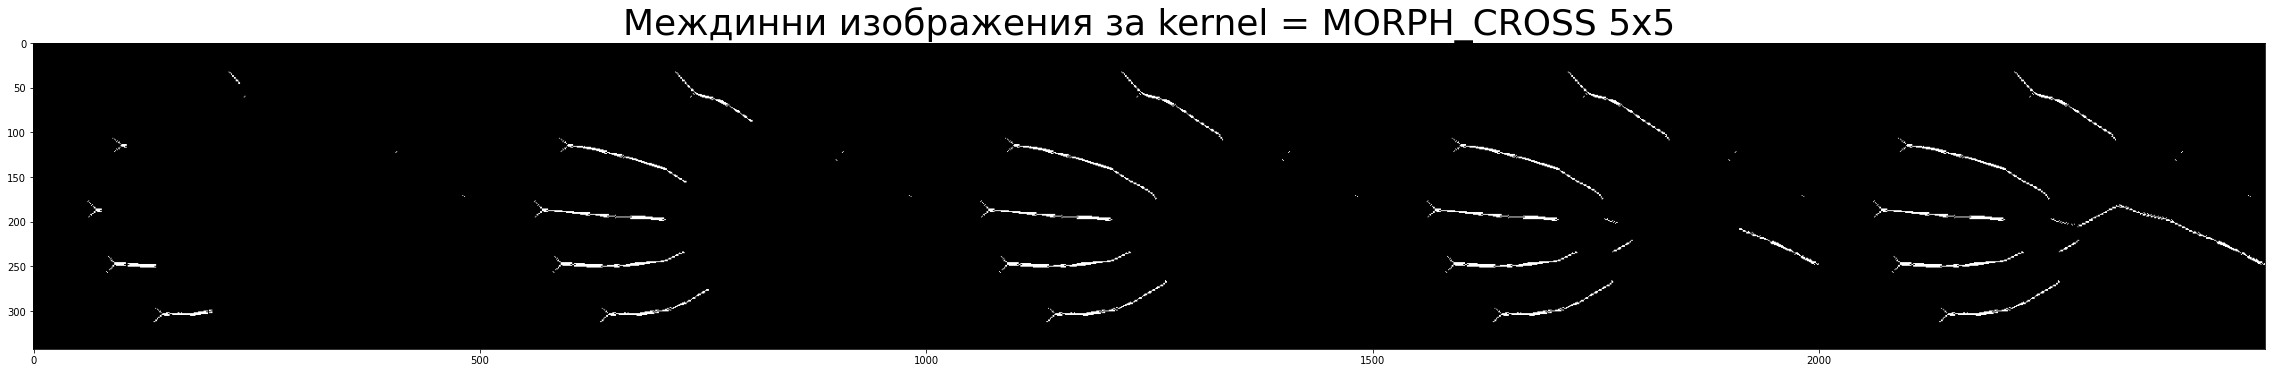

In [155]:
plt.figure(figsize=(40,10))
plt.title("Междинни изображения за kernel = MORPH_RECT 3x3", fontsize = 36)
len_0 = len(output_lists[0])
plt.imshow(np.concatenate(
    (output_lists[0][len_0 // 8], 
     output_lists[0][len_0 // 4],
     output_lists[0][len_0 // 2],
     output_lists[0][len_0 // 2 + len_0 // 4],
     output_lists[0][-1]
    ), axis=1), 'gray')

plt.figure(figsize=(40,10))
plt.title("Междинни изображения за kernel = MORPH_RECT 5x5", fontsize = 36)
len_1 = len(output_lists[1])
plt.imshow(np.concatenate(
    (output_lists[1][len_1 // 8], 
     output_lists[1][len_1 // 4],
     output_lists[1][len_1 // 2],
     output_lists[1][len_1 // 2 + len_1 // 4],
     output_lists[1][-1]
    ), axis=1), 'gray')


plt.figure(figsize=(40,10))
plt.title("Междинни изображения за kernel = MORPH_ELLIPSE 5x5", fontsize = 36)
len_1 = len(output_lists[1])
plt.imshow(np.concatenate(
    (output_lists[2][len_1 // 8], 
     output_lists[2][len_1 // 4],
     output_lists[2][len_1 // 2],
     output_lists[2][len_1 // 2 + len_1 // 4],
     output_lists[2][-1]
    ), axis=1), 'gray')

plt.figure(figsize=(40,10))
plt.title("Междинни изображения за kernel = MORPH_CROSS 5x5", fontsize = 36)
len_2 = len(output_lists[2])
plt.imshow(np.concatenate(
    (output_lists[3][len_2 // 8], 
     output_lists[3][len_2 // 4],
     output_lists[3][len_2 // 2],
     output_lists[3][len_2 // 2 + len_2 // 4],
     output_lists[3][-1]
    ), axis=1), 'gray')

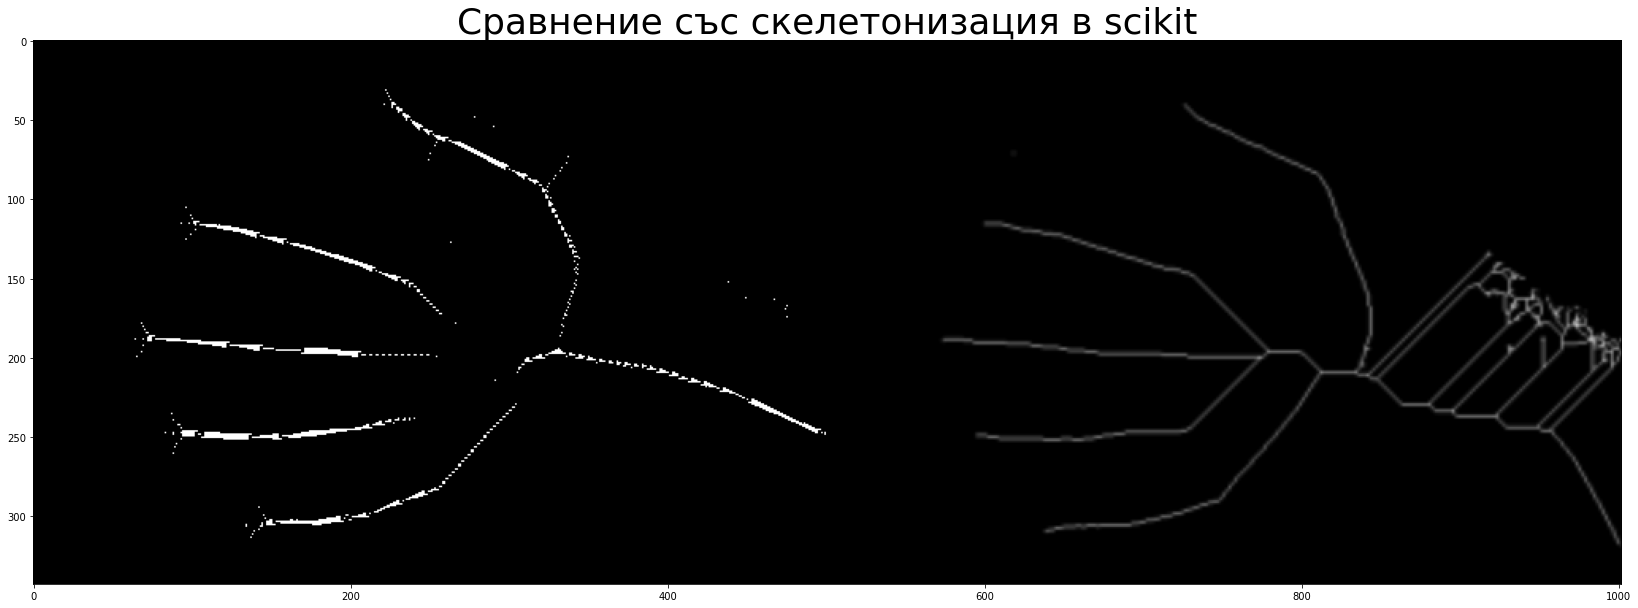

In [156]:
hand_skeleton_scikit = cv2.imread('images/skeleton_hand3_scikit.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(40,10))
plt.title("Сравнение със скелетонизация в scikit", fontsize = 36)
plt.imshow(np.concatenate((outputs[2], hand_skeleton_scikit), axis=1), 'gray')

### Анализ на сравнението със скелетонизацията в scikit

Алгоритъмът използван в scikit е описан от в статията [A Fast Parallel Algorithm for Thinning Digital Patterns ](http://agcggs680.pbworks.com/f/Zhan-Suen_algorithm.pdf). Едно от важните неща в него, както се вижда в `3. Thinning Algorithm` е, че едно от условията поставени пред алгоритъма е да бъде запазена свързаността. Предприемат се специални стъпки това да бъде вярно, което усложнява алгоритъма. Това усложнение обаче не пречи на алгоритъмът да може да се изпълнява паралелно.
Всяка итерация на този алгоритъм се състои от две под-итерации:

1. Премахване на югоизточните граници и северозападните ъгли
2. Премахване на северозападните граници и югоизточните ъгли

Пример - в a) са премахнати югоизточните граници и северозападните ъгли, в b) допълнително са премахнати северозападните граници и югоизточните ъгли. В c) виждаме финалния резултат:
![](images/zhan_suen_example.png)

Полученият скелетон чрез този алгоритъм гарантирано запазва свързаността. Това, обаче, не е без своите проблеми. В представените примери в представената научна статия получените резултати са перфектни - полученият скелетон е 1 пиксел широк и доста ясно запазва формата на изображението. В нашия пример с дланта алгоритъмът не се справя добре. Дланта е скелетонизирана по доста странен и неестествен начин - в крайния резултат тя се състои от паралелни линии под наклон, завършващи с разклонения.

### Запазване на свързаността при морфологична скелетонизация

Скелетонизацията чрез морфологични операции работи чрез много прости правила. Алгоритъмът не прави никакви допълнителни проверки и допускания - всяка стъпка се изпълнява, независимо дали това би нарушило свръзаността. По този начин голям брой обекти от реалния свят, след скелетонизация, ще доведе до нарушаване на свързаността.

Друг важен момент е изборът на структурен елемент.

## Източници:
- [1] - https://en.wikipedia.org/wiki/Morphological_skeleton
- [2] - https://medium.com/analytics-vidhya/skeletonization-in-python-using-opencv-b7fa16867331
- [3] - https://en.wikipedia.org/wiki/Mathematical_morphology
- [4] - http://www.inf.u-szeged.hu/~palagyi/skel/skel.html

http://www.stil.bas.bg/FSR2009/pap223.pdf

[1] Roli Bansal, Priti Sehgal & Punam Bedi - Effective Morphological Extraction of True
Fingerprint Minutiae based on the Hit or Miss Transform

[2] Lin Hong, Student Member, IEEE, Yifei Wan, and Anil Jain, Fellow, IEEE - Fingerprint
Image Enhancement: Algorithm and Performance Evaluation

[3] Pu Hongbin Chen Junali Zhang Yashe - Fingerprint Thinning Algorithm Based on
Mathematical Morphology